In [1]:
import xgboost as xgb
import pandas as pd
import numpy  as np
import os
import statsmodels
import matplotlib
%matplotlib inline

train_file = './data/titanic/train.csv'
test_file = './data/titanic/test.csv'

In [2]:
trainDF = pd.read_csv(train_file)
testDF = pd.read_csv(test_file)

noNaNEmbarked = np.array(~trainDF['Embarked'].isna())

In [3]:
# FEATURE ENGINEERING
# NAMES ande likely NOT imortant, nor is Ticket Number
cols_of_interest = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

y = trainDF['Survived'].loc[noNaNEmbarked]
X = trainDF[cols_of_interest].loc[noNaNEmbarked]

X.shape
y_train = np.array(y)


In [4]:
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Imputation is to replace NaN/None values with something else, in this case the string 'MISSING'
# OHE encodes categorical data
# Pipeline combines these operations into 1 "pipe"


0    549
1    340
Name: Survived, dtype: int64

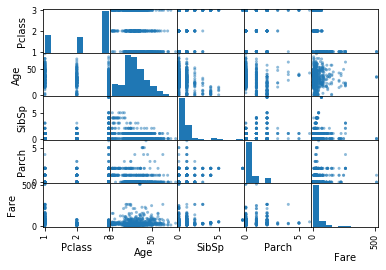

In [5]:
# Pandas table contains both numeric and string/"object" quantities
X.dtypes
# All columns that are NOT object will be numeric
kinds = np.array([dt.kind for dt in X.dtypes])
isnumeric = kinds !='O'

# Table data
all_cols= X.columns.values
numeric_cols = all_cols[isnumeric]
cat_cols = all_cols[~isnumeric]

pd.plotting.scatter_matrix(X);
# Not very strong linear correlation
X.corr()

# Check stratification of survival
# fairly balanced
y.value_counts()

In [6]:
# FOR CATEGORICAL DATA
cat_si_step = ('si', SimpleImputer(strategy='constant',
                fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)


In [7]:
# For NUMERICAL DATA
num_si_step = ('si', SimpleImputer(strategy='median')) # replace NaN with median values
# make mean go to zero and scale variance to 1
# Important for removing bias for variables with larger scale
num_ss_step = ('ss', StandardScaler())

num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)

In [8]:
# Put into ColumnTransformer
transformers = [('cat', cat_pipe, cat_cols) , ('num', num_pipe, numeric_cols)]
ct = ColumnTransformer(transformers=transformers)

X_train_ct = ct.fit_transform(X)
X_train_ct.shape
X_pred = ct.fit_transform(testDF[cols_of_interest])
X_pred.shape

(418, 10)

In [9]:
# Using xgboost.
# Transform data into DMatrix for optimised behaviour
dtrain = xgb.DMatrix(data=X_train_ct,label=y_train)

# Split into Train and Test
from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_ct, y_train, test_size=0.2, random_state=123)

# Classification Problem
xg_reg = xgb.XGBClassifier(objective="binary:logistic",reg_alpha=1,reg_lambda=1,learning_rate=0.3,max_depth=6, n_estimators=1000)

# Predict Single
xg_reg.fit(X_train_cv,y_train_cv)
preds = xg_reg.predict(X_test_cv)
score = sum([1 if y_test_cv[i]==preds[i] else 0 for i in range(len(y_test_cv))])/len(y_test_cv)
print(score)

0.8202247191011236


In [10]:
# Cross Validation
params={'objective':"binary:logistic",'learning_rate':0.3,'reg_alpha':1,'max_depth':6, 'n_estimators':1000}
#cv_results = xgb.cv(dtrain=dtrain, params=params,
#                    nfold=10, as_pandas=True, seed=123)
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

XGBoostError: [07:40:42] C:\dev\libs\xgboost\src\c_api\c_api.cc:817: Unknown uint field name group_ptr

In [ ]:
# Back to Pandas
testDF.head()
pID = testDF['PassengerId']
solution_dict = {'PassengerId':pID, 'Survived': y_pred }
solutionDF = pd.DataFrame(solution_dict)
solutionDF.to_csv('solution.csv', index=False)